# Data prep

## Import packages

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals
import warnings
import helpers
from helpers import DataSet
import matplotlib as mpl
import os

# Common imports
import pandas as pd
import numpy as np
import seaborn as sns

# Imports for ML
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier, PassiveAggressiveClassifier, RidgeClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import RobustScaler, StandardScaler, MaxAbsScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.decomposition import PCA

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
sns.set_style('whitegrid')

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "results"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)

# Helper functioins and structures
# Ignore useless warnings (see SciPy issue #5998)
warnings.filterwarnings(action="ignore", message="^internal gelsd")

## Load data

In [2]:
DATA_PATH = "Skyserver_SQL2_27_2018 6_51_39 PM.csv"
RESULTS_FOLDER = "results"

# We load the data. Those that have nothing to do with the features of the objects are ignored.
sdss_data = pd.read_csv(DATA_PATH)

# We have a general look at the features
sdss_data.head(3)

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid
0,1.237650e+18,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,752,301,4,267,3.722360e+18,STAR,-0.000009,3306,54922,491
1,1.237650e+18,183.598371,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,752,301,4,267,3.638140e+17,STAR,-0.000055,323,51615,541
2,1.237650e+18,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,752,301,4,268,3.232740e+17,GALAXY,0.123111,287,52023,513


## Drop not important features

In [3]:
print(sdss_data.columns.values)
sdss_data.drop(['objid', 'run', 'rerun', 'camcol', 'field',
                'specobjid', 'fiberid', 'mjd', 'plate'], axis=1, inplace=True)
sdss_data.head(1)

['objid' 'ra' 'dec' 'u' 'g' 'r' 'i' 'z' 'run' 'rerun' 'camcol' 'field'
 'specobjid' 'class' 'redshift' 'plate' 'mjd' 'fiberid']


,ra,dec,u,g,r,i,z,class,redshift
0,183.531326,0.089693,19.47406,17.0424,15.94699,15.50342,15.22531,STAR,-0.000009


## Feature engineering 

In [4]:
sdss_df_fe = sdss_data

# Principal Component Analysis
pca = PCA(n_components=3)
ugriz = pca.fit_transform(sdss_df_fe[['u', 'g', 'r', 'i', 'z']])

# update dataframe 
sdss_df_fe = pd.concat((sdss_df_fe, pd.DataFrame(ugriz)), axis=1)
sdss_df_fe.rename({0: 'PCA_1', 1: 'PCA_2', 2: 'PCA_3'}, axis=1, inplace = True)
sdss_df_fe.drop(['u', 'g', 'r', 'i', 'z'], axis=1, inplace=True)
sdss_df_fe.head()

,ra,dec,class,redshift,PCA_1,PCA_2,PCA_3
0,183.531326,0.089693,STAR,-0.000009,-1.507202,-1.377293,-0.265119
1,183.598371,0.135285,STAR,-0.000055,-0.195758,-0.028410,-0.155695
2,183.680207,0.126185,GALAXY,0.123111,1.297604,-0.590023,0.140338
3,183.870529,0.049911,STAR,-0.000111,-1.446117,0.566685,-0.009272
4,183.883288,0.102557,STAR,0.000590,-0.849271,1.287505,-0.397689


## Split into train/test sets

In [5]:
X = sdss_data.drop(['class'], axis=1)
y = sdss_data['class']

class_names = ["GALAXY", "QSO", "STAR"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## Scale the data

In [6]:
std_scaler = StandardScaler()

X_train_std_scaled = std_scaler.fit_transform(X_train.astype(np.float64))
X_test_std_scaled = std_scaler.fit_transform(X_test.astype(np.float64))

data_sets = []

std_scaled_set = DataSet("Standard Scaled", X_train_std_scaled, y_train, X_test_std_scaled, y_test)

data_sets.append(std_scaled_set)

# Classification

## Prepare result sets

In [7]:
result_sets = []

# Classfiers
knn_clf = KNeighborsClassifier(n_neighbors=3,
                              weights='distance', 
                              algorithm='auto',
                              leaf_size=23, 
                              p=2,
                              metric='manhattan', 
                              n_jobs=4)

lsvm_clf = LinearSVC(penalty='l2',
                   loss='squared_hinge',
                   dual=False,
                   C=303919.53823132074,
                   multi_class='ovr',
                   fit_intercept=True,
                   intercept_scaling=1.0,
                   class_weight='balanced',
                   verbose=False,
                   max_iter=10000,
                   random_state=42)

nusvm_clf = NuSVC(nu=0.01743328822199991,
               kernel="rbf",
               gamma=0.01743328822199991, 
               degree=7,
               coef0=4.5203536563602496e-05, 
               shrinking=True,
               probability=True,
               tol=0.001,
               cache_size=20, 
               class_weight="balanced",
               verbose=False,
               max_iter=100000,
               random_state=42)

rbf_svm_clf = SVC(kernel="rbf",
                  C=18329.8071083243,
                  gamma=0.004281332398719387,
                  degree=8,
                  coef0=0.0007847599703514606,
                  shrinking=True,
                  probability=True,
                  tol=0.001,
                  cache_size=100,
                  class_weight=None,
                  verbose=False,
                  max_iter=-1,
                  random_state=42)

poly_svm_clf = SVC(kernel='poly',
             C=788.0462815669937,
             gamma=0.0004893900918477499, 
             degree=4,
             coef0=22.122162910704503, 
             shrinking=False,
             probability=True, 
             tol=0.001, 
             cache_size=50,
             class_weight=None, 
             verbose=False, 
             max_iter=100000, 
             random_state=42)

tree_clf = DecisionTreeClassifier(criterion="entropy",
                                  splitter="best",
                                  max_depth=3,
                                  min_weight_fraction_leaf=0.0014384498882876629,
                                  max_leaf_nodes=9,
                                  presort=True,
                                  min_samples_split=6,
                                  min_samples_leaf=4,
                                  max_features=None,
                                  random_state=42)

rnd_clf = RandomForestClassifier(n_estimators=100,
                                 criterion="entropy",
                                 min_samples_split=4,
                                 min_samples_leaf=2,
                                 max_features=None,
                                 bootstrap=True,
                                 oob_score=True,
                                 random_state=42)

log_clf = LogisticRegression(penalty='l1',
                             dual=False,
                             C=31.622776601683793,
                             fit_intercept=True,
                             intercept_scaling=0.5878016072274912,
                             class_weight='balanced',
                             solver='saga',
                             multi_class='multinomial',
                             warm_start=False,
                             n_jobs=4,
                             max_iter=1000,
                             random_state=42)

gb_clf = GradientBoostingClassifier(loss="deviance",
                                    learning_rate=0.18329807108324356,
                                    n_estimators=83,
                                    criterion="friedman_mse",
                                    min_samples_split=3,
                                    min_samples_leaf=7,
                                    max_depth=7,
                                    random_state=42)

xgb_clf = XGBClassifier(eta=0.01778279410038923,
                        gamma=0.01,
                        max_depth=4,
                        min_child_weight=0.03831186849557289,
                        max_delta_step=0.35938136638046275,
                        subsample=1.0,
                        reg_lambda=5.994842503189409,
                        alpha=1.7782794100389228e-08,
                        colsample_bytree=0.9,
                        objective="multi:softprob",
                        seed=42,
                        n_estimators=4216,
                        nthread=4)

bag_df_clf = BaggingClassifier(n_estimators=261,
                               max_samples=46,
                               max_features=6,
                               bootstrap=False,
                               bootstrap_features=False,
                               oob_score=False,
                               n_jobs=4,
                               random_state=42)

ada_clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3),
                             n_estimators=825,
                             learning_rate=0.19573417814876617,
                             algorithm='SAMME',
                             random_state=42)

sgd_clf = SGDClassifier(loss='perceptron',
                        penalty='l1',
                        alpha=0.00510896977450693,
                        l1_ratio=0.014677992676220698,
                        fit_intercept=True,
                        shuffle=True,
                        epsilon=0.4216965034285822,
                        n_jobs=4,
                        random_state=42,
                        learning_rate='optimal',
                        eta0=0.2,
                        power_t=0.014677992676220698,
                        early_stopping=True,
                        n_iter_no_change=5,
                        class_weight=None,
                        average=False)

mlp_clf = MLPClassifier(hidden_layer_sizes=(20, 20),
                       activation='relu',
                       solver='sgd', 
                       alpha=1e-05, 
                       batch_size=3, 
                       learning_rate='adaptive',
                       learning_rate_init=0.1333521432163324, 
                       power_t=0.004216965034285823, 
                       max_iter=1000,
                       random_state=42,
                       momentum=0.1,
                       nesterovs_momentum=True, 
                       early_stopping=True,
                       beta_1=0.7, 
                       beta_2=0.4210900698456838, 
                       epsilon=1e-08,
                       n_iter_no_change=5)

xtree_clf = ExtraTreesClassifier(n_estimators=2154,
                                 criterion="gini",
                                 min_samples_split=2,
                                 min_samples_leaf=1,
                                 max_features=None,
                                 bootstrap=False,
                                 oob_score=False,
                                 random_state=42)

pa_clf = PassiveAggressiveClassifier(loss='hinge',
                                     shuffle=False,
                                     n_jobs=4,
                                     random_state=42,
                                     early_stopping=True,
                                     warm_start=False,
                                     class_weight='balanced',
                                     average=False)

r_clf = RidgeClassifier(alpha=0.11006941712522103,
                        fit_intercept=False,
                        normalize=False,
                        copy_X=True,
                        max_iter=3000,
                        class_weight=None,
                        solver='cholesky',
                        random_state=42)

nb_clf = GaussianNB(var_smoothing=3.727593720314938e-11)

lda_clf = LinearDiscriminantAnalysis(
    solver="svd", shrinkage=None, n_components=None, store_covariance=False)

qda_clf = QuadraticDiscriminantAnalysis(
    reg_param=2.1544346900318867e-07, store_covariance=False)

v_clf = VotingClassifier(estimators=[("PolyKernelSVM", poly_svm_clf),
                                     ("GradientBoostingClassifier", gb_clf), 
                                     ("RandomForestClassifier", rnd_clf)]) 


# CLF names
clf_names = ["KNN",
             "LinearSVM",
             "NuSVC", 
             "RbfKernelSVM", 
             "PolyKernelSVM",
             "DecisionTreeClassifier",
             "RandomForestClassifier", 
             "LogisticRegression", 
             "GradientBoostingClassifier", 
             "XGBClassifier", 
             "BaggingClassifier",
             "AdaBoostClassifier",
             "SGDClassifier",
             "MLPClassifier", 
             "ExtraTreesClassifier",
             "PassiveAggressiveClassifier",
             "RidgeClassifier",
             "GaussianNB", 
             "LinearDiscriminantAnalysis",
             "QuadraticDiscriminantAnalysis",
             "VotingClassifier"]

clfs = [knn_clf,
        lsvm_clf,
        nusvm_clf,
        rbf_svm_clf,
        poly_svm_clf,
        tree_clf,
        rnd_clf,
        log_clf,
        gb_clf,
        xgb_clf,
        bag_df_clf,
        ada_clf,
        sgd_clf,
        mlp_clf,
        xtree_clf,
        pa_clf,
        r_clf,
        nb_clf,
        lda_clf,
        qda_clf,
        v_clf
        ]

## Run

Data Set Type:  Standard Scaled
[0.9320453  0.91472352 0.932      0.92661775 0.91927952]
Accuracy: 0.925 (+/- 0.014)
KNN :
 [[1086    2  158]
 [  13  216   13]
 [ 107    1  904]]


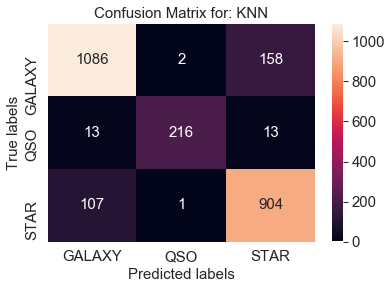

              precision    recall  f1-score   support

      GALAXY       0.90      0.87      0.89      1246
         QSO       0.99      0.89      0.94       242
        STAR       0.84      0.89      0.87      1012

   micro avg       0.88      0.88      0.88      2500
   macro avg       0.91      0.89      0.90      2500
weighted avg       0.88      0.88      0.88      2500



[0.97734843 0.97668221 0.988      0.98599066 0.98398933]
Accuracy: 0.982 (+/- 0.009)
LinearSVM :
 [[1222   11   13]
 [  14  228    0]
 [   4    1 1007]]


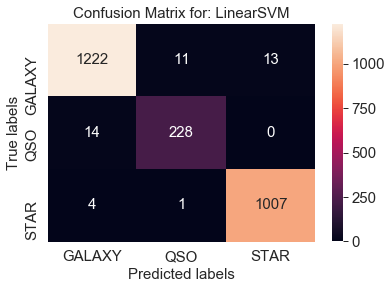

              precision    recall  f1-score   support

      GALAXY       0.99      0.98      0.98      1246
         QSO       0.95      0.94      0.95       242
        STAR       0.99      1.00      0.99      1012

   micro avg       0.98      0.98      0.98      2500
   macro avg       0.97      0.97      0.97      2500
weighted avg       0.98      0.98      0.98      2500



[0.98934044 0.98201199 0.98866667 0.98999333 0.98532355]
Accuracy: 0.987 (+/- 0.006)
NuSVC :
 [[1214    4   28]
 [   7  235    0]
 [  35    1  976]]


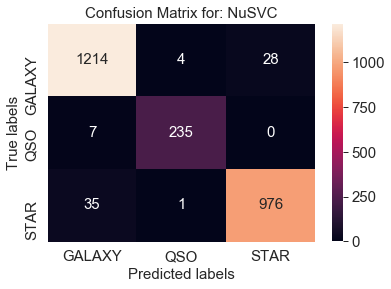

              precision    recall  f1-score   support

      GALAXY       0.97      0.97      0.97      1246
         QSO       0.98      0.97      0.98       242
        STAR       0.97      0.96      0.97      1012

   micro avg       0.97      0.97      0.97      2500
   macro avg       0.97      0.97      0.97      2500
weighted avg       0.97      0.97      0.97      2500



[0.98867422 0.98667555 0.994      0.99266177 0.98932622]
Accuracy: 0.990 (+/- 0.005)
RbfKernelSVM :
 [[1226    5   15]
 [   9  233    0]
 [   1    3 1008]]


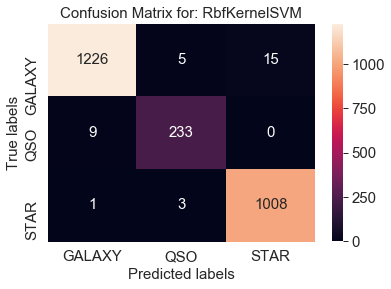

              precision    recall  f1-score   support

      GALAXY       0.99      0.98      0.99      1246
         QSO       0.97      0.96      0.96       242
        STAR       0.99      1.00      0.99      1012

   micro avg       0.99      0.99      0.99      2500
   macro avg       0.98      0.98      0.98      2500
weighted avg       0.99      0.99      0.99      2500



[0.99067288 0.98667555 0.99333333 0.99199466 0.99066044]
Accuracy: 0.991 (+/- 0.004)
PolyKernelSVM :
 [[1226    4   16]
 [   7  235    0]
 [   1    1 1010]]


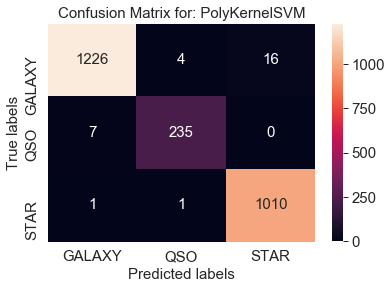

              precision    recall  f1-score   support

      GALAXY       0.99      0.98      0.99      1246
         QSO       0.98      0.97      0.98       242
        STAR       0.98      1.00      0.99      1012

   micro avg       0.99      0.99      0.99      2500
   macro avg       0.99      0.98      0.98      2500
weighted avg       0.99      0.99      0.99      2500



[0.98800799 0.98667555 0.992      0.98665777 0.99199466]
Accuracy: 0.989 (+/- 0.005)
DecisionTreeClassifier :
 [[1229   10    7]
 [  17  225    0]
 [   2    0 1010]]


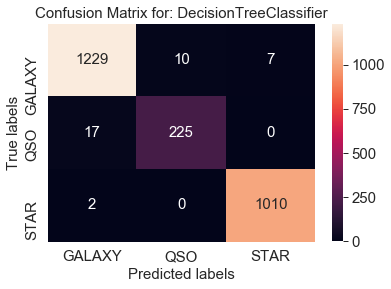

              precision    recall  f1-score   support

      GALAXY       0.98      0.99      0.99      1246
         QSO       0.96      0.93      0.94       242
        STAR       0.99      1.00      1.00      1012

   micro avg       0.99      0.99      0.99      2500
   macro avg       0.98      0.97      0.97      2500
weighted avg       0.99      0.99      0.99      2500



[0.98800799 0.98867422 0.99533333 0.98799199 0.99533022]
Accuracy: 0.991 (+/- 0.007)
RandomForestClassifier :
 [[1230    8    8]
 [  12  230    0]
 [   1    0 1011]]


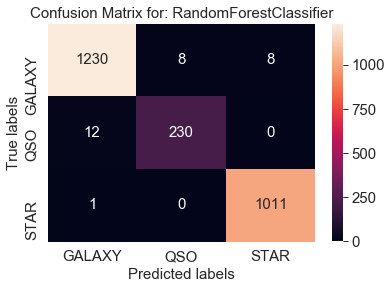

              precision    recall  f1-score   support

      GALAXY       0.99      0.99      0.99      1246
         QSO       0.97      0.95      0.96       242
        STAR       0.99      1.00      1.00      1012

   micro avg       0.99      0.99      0.99      2500
   macro avg       0.98      0.98      0.98      2500
weighted avg       0.99      0.99      0.99      2500



[0.98467688 0.98201199 0.984      0.99132755 0.9826551 ]
Accuracy: 0.985 (+/- 0.007)
LogisticRegression :
 [[1205    9   32]
 [   5  237    0]
 [   0    3 1009]]


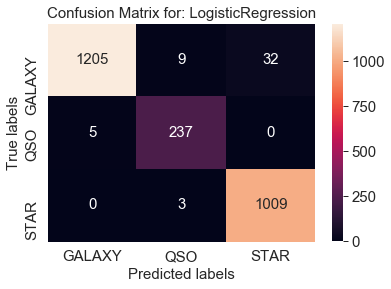

              precision    recall  f1-score   support

      GALAXY       1.00      0.97      0.98      1246
         QSO       0.95      0.98      0.97       242
        STAR       0.97      1.00      0.98      1012

   micro avg       0.98      0.98      0.98      2500
   macro avg       0.97      0.98      0.98      2500
weighted avg       0.98      0.98      0.98      2500



[0.99000666 0.98800799 0.99666667 0.98599066 0.99266177]
Accuracy: 0.991 (+/- 0.007)
GradientBoostingClassifier :
 [[1233    6    7]
 [  13  229    0]
 [   2    0 1010]]


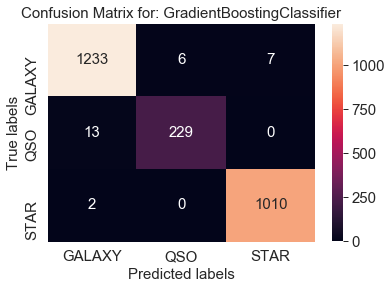

              precision    recall  f1-score   support

      GALAXY       0.99      0.99      0.99      1246
         QSO       0.97      0.95      0.96       242
        STAR       0.99      1.00      1.00      1012

   micro avg       0.99      0.99      0.99      2500
   macro avg       0.99      0.98      0.98      2500
weighted avg       0.99      0.99      0.99      2500



[0.98867422 0.98600933 0.99533333 0.98665777 0.993996  ]
Accuracy: 0.990 (+/- 0.008)
XGBClassifier :
 [[1231    7    8]
 [  12  230    0]
 [   1    0 1011]]


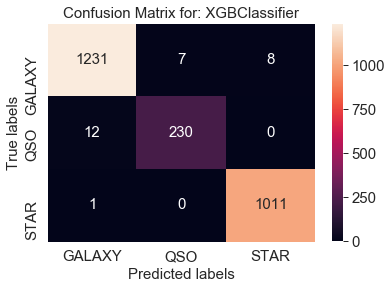

              precision    recall  f1-score   support

      GALAXY       0.99      0.99      0.99      1246
         QSO       0.97      0.95      0.96       242
        STAR       0.99      1.00      1.00      1012

   micro avg       0.99      0.99      0.99      2500
   macro avg       0.98      0.98      0.98      2500
weighted avg       0.99      0.99      0.99      2500



[0.98201199 0.97268488 0.98133333 0.97264843 0.98398933]
Accuracy: 0.979 (+/- 0.010)
BaggingClassifier :
 [[1218    9   19]
 [  24  218    0]
 [   0    0 1012]]


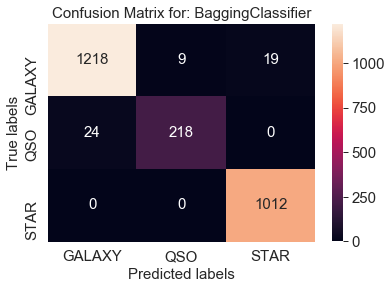

              precision    recall  f1-score   support

      GALAXY       0.98      0.98      0.98      1246
         QSO       0.96      0.90      0.93       242
        STAR       0.98      1.00      0.99      1012

   micro avg       0.98      0.98      0.98      2500
   macro avg       0.97      0.96      0.97      2500
weighted avg       0.98      0.98      0.98      2500



[0.99000666 0.98667555 0.994      0.98732488 0.99332889]
Accuracy: 0.990 (+/- 0.006)
AdaBoostClassifier :
 [[1234    6    6]
 [  11  231    0]
 [   2    0 1010]]


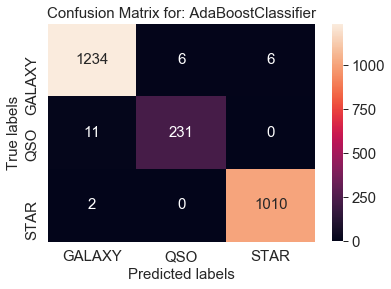

              precision    recall  f1-score   support

      GALAXY       0.99      0.99      0.99      1246
         QSO       0.97      0.95      0.96       242
        STAR       0.99      1.00      1.00      1012

   micro avg       0.99      0.99      0.99      2500
   macro avg       0.99      0.98      0.98      2500
weighted avg       0.99      0.99      0.99      2500



[0.97734843 0.98267821 0.988      0.98665777 0.99066044]
Accuracy: 0.985 (+/- 0.009)
SGDClassifier :
 [[1230    3   13]
 [  22  220    0]
 [ 146    2  864]]


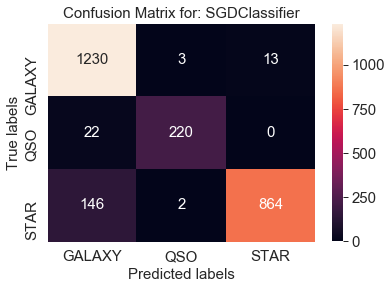

              precision    recall  f1-score   support

      GALAXY       0.88      0.99      0.93      1246
         QSO       0.98      0.91      0.94       242
        STAR       0.99      0.85      0.91      1012

   micro avg       0.93      0.93      0.93      2500
   macro avg       0.95      0.92      0.93      2500
weighted avg       0.93      0.93      0.93      2500



[0.98667555 0.98067955 0.98933333 0.98799199 0.98532355]
Accuracy: 0.986 (+/- 0.006)
MLPClassifier :
 [[1182    6   58]
 [   9  232    1]
 [  11    1 1000]]


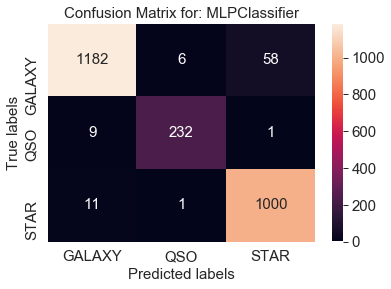

              precision    recall  f1-score   support

      GALAXY       0.98      0.95      0.97      1246
         QSO       0.97      0.96      0.96       242
        STAR       0.94      0.99      0.97      1012

   micro avg       0.97      0.97      0.97      2500
   macro avg       0.97      0.97      0.97      2500
weighted avg       0.97      0.97      0.97      2500



[0.98800799 0.98467688 0.994      0.98799199 0.99132755]
Accuracy: 0.989 (+/- 0.006)
ExtraTreesClassifier :
 [[1234    5    7]
 [  14  228    0]
 [   1    0 1011]]


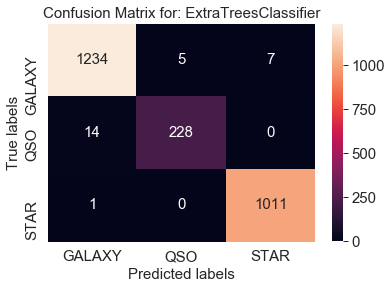

              precision    recall  f1-score   support

      GALAXY       0.99      0.99      0.99      1246
         QSO       0.98      0.94      0.96       242
        STAR       0.99      1.00      1.00      1012

   micro avg       0.99      0.99      0.99      2500
   macro avg       0.99      0.98      0.98      2500
weighted avg       0.99      0.99      0.99      2500



[0.97468354 0.97001999 0.98466667 0.97998666 0.96264176]
Accuracy: 0.974 (+/- 0.015)
PassiveAggressiveClassifier :
 [[1106    8  132]
 [  11  231    0]
 [ 128    1  883]]


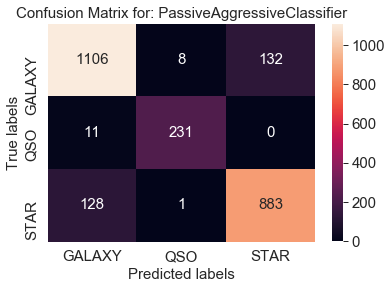

              precision    recall  f1-score   support

      GALAXY       0.89      0.89      0.89      1246
         QSO       0.96      0.95      0.96       242
        STAR       0.87      0.87      0.87      1012

   micro avg       0.89      0.89      0.89      2500
   macro avg       0.91      0.90      0.91      2500
weighted avg       0.89      0.89      0.89      2500



[0.9260493  0.91538974 0.938      0.9179453  0.91861241]
Accuracy: 0.923 (+/- 0.016)
RidgeClassifier :
 [[1055   15  176]
 [  19  222    1]
 [  43    2  967]]


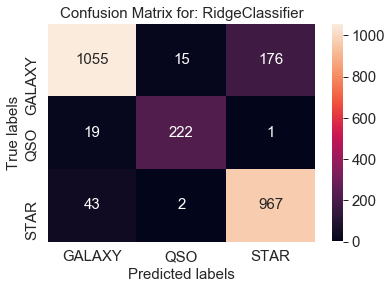

              precision    recall  f1-score   support

      GALAXY       0.94      0.85      0.89      1246
         QSO       0.93      0.92      0.92       242
        STAR       0.85      0.96      0.90      1012

   micro avg       0.90      0.90      0.90      2500
   macro avg       0.91      0.91      0.90      2500
weighted avg       0.90      0.90      0.90      2500



[0.98001332 0.9733511  0.98066667 0.97464977 0.98465644]
Accuracy: 0.979 (+/- 0.008)
GaussianNB :
 [[1218   21    7]
 [  11  231    0]
 [   3    7 1002]]


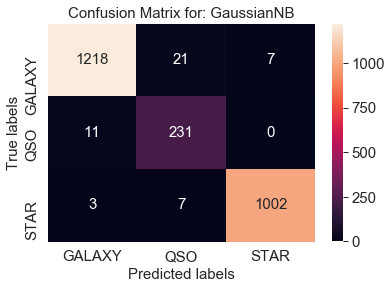

              precision    recall  f1-score   support

      GALAXY       0.99      0.98      0.98      1246
         QSO       0.89      0.95      0.92       242
        STAR       0.99      0.99      0.99      1012

   micro avg       0.98      0.98      0.98      2500
   macro avg       0.96      0.97      0.97      2500
weighted avg       0.98      0.98      0.98      2500



[0.93537642 0.91672219 0.946      0.9299533  0.92328219]
Accuracy: 0.930 (+/- 0.020)
LinearDiscriminantAnalysis :
 [[1131    0  115]
 [  45  185   12]
 [  74    2  936]]


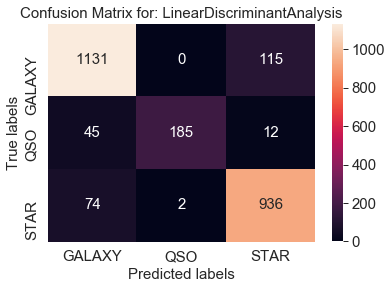

              precision    recall  f1-score   support

      GALAXY       0.90      0.91      0.91      1246
         QSO       0.99      0.76      0.86       242
        STAR       0.88      0.92      0.90      1012

   micro avg       0.90      0.90      0.90      2500
   macro avg       0.92      0.87      0.89      2500
weighted avg       0.90      0.90      0.90      2500



[0.98001332 0.98134577 0.98666667 0.98932622 0.98732488]
Accuracy: 0.985 (+/- 0.007)
QuadraticDiscriminantAnalysis :
 [[1225   15    6]
 [   5  237    0]
 [   5    2 1005]]


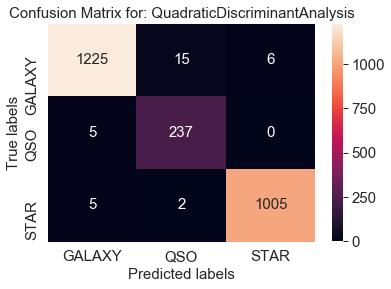

              precision    recall  f1-score   support

      GALAXY       0.99      0.98      0.99      1246
         QSO       0.93      0.98      0.96       242
        STAR       0.99      0.99      0.99      1012

   micro avg       0.99      0.99      0.99      2500
   macro avg       0.97      0.99      0.98      2500
weighted avg       0.99      0.99      0.99      2500



[0.99000666 0.98934044 0.99666667 0.98732488 0.99466311]
Accuracy: 0.992 (+/- 0.007)
VotingClassifier :
 [[1232    6    8]
 [  11  231    0]
 [   1    0 1011]]


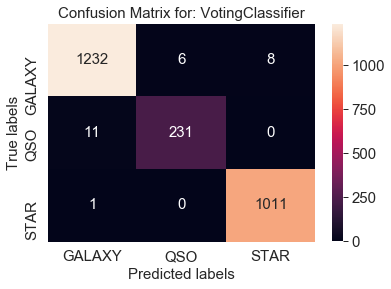

              precision    recall  f1-score   support

      GALAXY       0.99      0.99      0.99      1246
         QSO       0.97      0.95      0.96       242
        STAR       0.99      1.00      1.00      1012

   micro avg       0.99      0.99      0.99      2500
   macro avg       0.99      0.98      0.98      2500
weighted avg       0.99      0.99      0.99      2500



By Acc:
VotingClassifier 0.9916003521186749
RandomForestClassifier 0.9910675520003934
PolyKernelSVM 0.9906673742225367
GradientBoostingClassifier 0.9906667517037414
RbfKernelSVM 0.9902675517633565
AdaBoostClassifier 0.9902671962076427
XGBClassifier 0.9901341293633168
ExtraTreesClassifier 0.9892008846226155
DecisionTreeClassifier 0.9890671958520871
NuSVC 0.9870671952594942
MLPClassifier 0.9860007947262792
SGDClassifier 0.985068972208432
QuadraticDiscriminantAnalysis 0.9849353722675728
LogisticRegression 0.9849343058374693
LinearSVM 0.9824021265787228
GaussianNB 0.9786674589040558
BaggingClassifier 0.97853359211

In [8]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sns.set_context("paper", rc={"font.size":15,
                              "axes.titlesize":15,
                             "axes.labelsize":15,
                              "xtick.labelsize":15,
                              "ytick.labelsize":15,
#                              "legend.fontsize":27
                                }) 
    result_sets = helpers.learning_loop_for_sets(clfs, clf_names, class_names, data_sets)

In [8]:
matrices = []